In [1]:
import os
import glob

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from desilike.samples import Chain, plotting

In [3]:
# These lines of code are setting various parameters for the appearance of plots created using the matplotlib library. 
plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size = 20)
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['figure.figsize'] = (30.0, 8.0)
plt.rcParams['xtick.major.width']  = 1
plt.rcParams['ytick.major.width']  = 1
plt.rcParams['xtick.major.pad']= 8

In [4]:
tracer = 'QSO'
region = 'NGC' # choices=['NGC', 'SGC', 'NS', 'S', 'NGCS', 'SGCS', 'NScomb']
theory_name = 'fs'
clustering_statistics = 'pk' # choices=['pk', 'xi']
on_the_fly_GaussianCovariance_matrix = 'on_the_fly_GaussianCovariance_matrix' # choices=['on_the_fly_GaussianCovariance_matrix', '']
zmin, zmax, b0 = {'LRG': (0.4, 1.1, 1.7), 'ELG': (1.1, 1.6, 0.84), 'QSO': (0.8, 2.1, 1.2)}[tracer]

In [5]:
base_dir = '/global/homes/u/uendert/desi-y1-kp45/blinding/' #'/global/cfs/cdirs/desi/users/uendert/blinding/' #'/global/homes/u/uendert/desi-y1-kp45/blinding' #'..'
chain_fn = sorted(glob.glob(os.path.join(base_dir, 'blinded', 'test_w0-*','{}'.format(on_the_fly_GaussianCovariance_matrix), '{}'.format(theory_name), '{}'.format(clustering_statistics), 'chain_{}_{}_{}_{}.npy'.format(tracer, region, zmin, zmax))))
chain_unblinded_fn = os.path.join(base_dir, 'unblinded','{}'.format(on_the_fly_GaussianCovariance_matrix), '{}'.format(theory_name), '{}'.format(clustering_statistics),'chain_{}_{}_{}_{}.npy'.format(tracer, region, zmin, zmax))

In [6]:
chain_fn

['/global/homes/u/uendert/desi-y1-kp45/blinding/blinded/test_w0-0.9040043101843285_wa0.025634205416364297/on_the_fly_GaussianCovariance_matrix/fs/pk/chain_QSO_NGC_0.8_2.1.npy',
 '/global/homes/u/uendert/desi-y1-kp45/blinding/blinded/test_w0-0.9057030601797708_wa-0.6831142329608426/on_the_fly_GaussianCovariance_matrix/fs/pk/chain_QSO_NGC_0.8_2.1.npy',
 '/global/homes/u/uendert/desi-y1-kp45/blinding/blinded/test_w0-0.970439944958287_wa-0.507777992481059/on_the_fly_GaussianCovariance_matrix/fs/pk/chain_QSO_NGC_0.8_2.1.npy',
 '/global/homes/u/uendert/desi-y1-kp45/blinding/blinded/test_w0-0.996229742129104_wa0.28930866494014884/on_the_fly_GaussianCovariance_matrix/fs/pk/chain_QSO_NGC_0.8_2.1.npy',
 '/global/homes/u/uendert/desi-y1-kp45/blinding/blinded/test_w0-1.0485430984101343_wa0.14015686872763022/on_the_fly_GaussianCovariance_matrix/fs/pk/chain_QSO_NGC_0.8_2.1.npy',
 '/global/homes/u/uendert/desi-y1-kp45/blinding/blinded/test_w0-1.106392086529483_wa0.45478607672455995/on_the_fly_Gaussia

In [7]:
bestfit = {name: [] for name in ['qpar', 'qper', 'dm', 'df', 'chi2min']}
error = {name: [] for name in ['qpar', 'qper', 'dm', 'df']}
expected = {name: [] for name in ['qpar', 'qper', 'dm', 'df']}
expected_unblinded = {}

from desilike.samples import Profiles
chain_unblinded = Chain.load(chain_unblinded_fn)

bestfit_unblinded = {name: chain_unblinded.mean('{}'.format(name)) for name in error}
bestfit_unblinded['qiso'] = chain_unblinded.mean('qpar')**(1./3.) * chain_unblinded.mean('qper')**(2./3.)
bestfit_unblinded['chi2min'] = -2 * chain_unblinded.logposterior.max()

error_unblinded = {name: chain_unblinded.std('{}'.format(name)) for name in error}
for name in error_unblinded: error_unblinded[name] = error_unblinded[name]
                   
expected_unblinded['qpar'] = chain_unblinded.attrs['expected']['qpar']
expected_unblinded['qper'] = chain_unblinded.attrs['expected']['qper']
expected_unblinded['dm'] = chain_unblinded.attrs['expected']['dm']
expected_unblinded['df'] = chain_unblinded.attrs['expected']['df']

cov_unblinded = chain_unblinded.covariance(params=['qper', 'qpar'])
jac = np.array([2.0 / 3.0, 1.0 / 3.0])
qiso_error_unblinded = {'qiso': jac.dot(cov_unblinded).dot(jac)**0.5}

qiso_error = []

for chain_fn_ in chain_fn:
    chain_ = Chain.load(chain_fn_)
    for name in expected: expected[name].append(chain_.attrs['expected'][name])
    for name in error: bestfit[name].append(float(chain_.mean('{}'.format(name))))
    for name in error: error[name].append(float(chain_.std('{}'.format(name))))
    cov = chain_.covariance(params=['qper', 'qpar'])
    jac = np.array([2.0 / 3.0, 1.0 / 3.0])
    qiso_error.append(jac.dot(cov).dot(jac)**0.5)

    bestfit['chi2min'].append(float( -2 * chain_.logposterior.max()))


bestfit['qiso'] = list(np.array(bestfit['qpar'])**(1./3.) * np.array(bestfit['qper'])**(2./3.))
expected['qiso'] = list(np.array(expected['qpar'])**(1./3.) * np.array(expected['qper'])**(2./3.))
expected['dm'] = [0.] * len(expected['dm'])
error['qiso'] = qiso_error

error_unblinded['qiso'] = qiso_error_unblinded['qiso']

In [8]:
expected

{'qpar': [1.0212203748447715,
  0.9797029906064666,
  0.9789113519394073,
  1.0202514363339066,
  0.9996844535993473,
  1.008551218458552,
  0.993745349777956,
  1.0040453837423848],
 'qper': [1.0206681548815957,
  0.9918981884343928,
  0.9867460380434073,
  1.0127978087891119,
  0.996252569903178,
  0.997592569695291,
  0.9844075069824675,
  0.9858877427943937],
 'dm': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'df': [0.9788392100541494,
  0.76424184168928,
  0.7636432109399818,
  0.978270222071201,
  0.8428762531984677,
  0.9032268345861723,
  0.777065058520042,
  0.8004902209111129],
 'qiso': [1.0208521950157594,
  0.9878163480219246,
  0.9841275334918347,
  1.0152762811526108,
  0.9973952200735396,
  1.001232157898474,
  0.9875103309607928,
  0.9919035076636503]}

In [9]:
error_unblinded

{'qpar': array([0.02027026]),
 'qper': array([0.01461254]),
 'dm': array([0.04284085]),
 'df': array([0.07439531]),
 'qiso': 0.011241788942558032}

In [10]:
import pandas as pd

In [11]:
df_error_unblinded = pd.DataFrame(error_unblinded, index=[0])
df_error_unblinded.rename(columns={"qpar": "qpar_err", "qper": "qper_err", "dm": "dm_err", "df": "df_err", "qiso": "qiso_err"}, inplace=True)
df_error = pd.DataFrame(error)
df_error.rename(columns={"qpar": "qpar_err", "qper": "qper_err", "dm": "dm_err", "df": "df_err", "qiso": "qiso_err"}, inplace=True)

In [12]:
df_error_unblinded

,qpar_err,qper_err,dm_err,df_err,qiso_err
0,0.02027,0.014613,0.042841,0.074395,0.011242


In [13]:
df_error

,qpar_err,qper_err,dm_err,df_err,qiso_err
0,0.019860,0.014543,0.035734,0.071046,0.011963
1,0.021845,0.014218,0.048907,0.071324,0.010876
2,0.021487,0.015500,0.050819,0.084065,0.011313
3,0.019344,0.014389,0.034387,0.071595,0.011389
4,0.021755,0.014491,0.044352,0.075472,0.011503
5,0.021626,0.014767,0.038798,0.072358,0.011878
6,0.022412,0.015770,0.047052,0.079535,0.011929
7,0.022819,0.015448,0.046742,0.072255,0.011649


In [14]:
chain_unblinded

Chain(shape=(480, 40), params=ParameterCollection(['qpar', 'qper', 'dm', 'df', 'b1', 'b2', 'bs', 'logposterior', 'dn', 'b3', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2', 'sn4', 'loglikelihood', 'logprior', 'aweight', 'fweight']))

In [15]:
unblinded_cosmo = {'w0': -1.0, 'wa': 0.0, 'f': 0.8}
unblinded_cosmo.update(bestfit_unblinded)
unblinded_cosmo.update({'ndof': chain_unblinded.attrs['ndof']})
cosmo_unblinded = pd.DataFrame(unblinded_cosmo, index=[0])
cosmo_unblinded = pd.concat([cosmo_unblinded, df_error_unblinded], axis=1)
cosmo_unblinded

,w0,wa,f,qpar,qper,dm,df,qiso,chi2min,ndof,qpar_err,qper_err,dm_err,df_err,qiso_err
0,-1.0,0.0,0.8,1.013945,0.998429,-0.01709,1.030001,1.003575,102.301023,155,0.02027,0.014613,0.042841,0.074395,0.011242


In [16]:
chain_unblinded.attrs['ndof']

155

In [17]:
base = '/global/cfs/cdirs/desi/survey/catalogs/main/mocks/FirstGenMocks/AbacusSummit/Y1/mock1/LSScats/'
data_dir = base + 'blinded/jmena/test_w0-*/LSScats/blinded/'
fn_list = sorted(glob.glob(os.path.join(data_dir, 'blinded_parameters_{}.csv'.format(tracer))))

cosmo_blinded = {name: [] for name in ['w0', 'wa', 'f']}
ndof = {name: [] for name in ['ndof']}
for j, chain_fn_ in zip(fn_list, chain_fn):
    chain_ = Chain.load(chain_fn_)
    w0_blind, wa_blind, f_blind = np.loadtxt(j, delimiter=',', skiprows=1)
    cosmo_blinded['w0'].append(w0_blind)
    cosmo_blinded['wa'].append(wa_blind)
    cosmo_blinded['f'].append(f_blind)
    ndof['ndof'].append(chain_.attrs['ndof'])

cosmo_blinded.update(bestfit)
cosmo_blinded.update(df_error)
cosmo_blinded.update(ndof)
cosmo_blinded = pd.DataFrame(cosmo_blinded)

blinded_concat = pd.concat([cosmo_unblinded, cosmo_blinded ], axis=0)

In [18]:
cosmo_unblinded

,w0,wa,f,qpar,qper,dm,df,qiso,chi2min,ndof,qpar_err,qper_err,dm_err,df_err,qiso_err
0,-1.0,0.0,0.8,1.013945,0.998429,-0.01709,1.030001,1.003575,102.301023,155,0.02027,0.014613,0.042841,0.074395,0.011242


In [19]:
blinded_concat

,w0,wa,f,qpar,qper,dm,df,qiso,chi2min,ndof,qpar_err,qper_err,dm_err,df_err,qiso_err
0,-1.000000,0.000000,0.800000,1.013945,0.998429,-0.017090,1.030001,1.003575,102.301023,155,0.020270,0.014613,0.042841,0.074395,0.011242
0,-0.904004,0.025634,0.880000,1.000451,1.017021,0.006231,1.239401,1.011467,123.785756,155,0.019860,0.014543,0.035734,0.071046,0.011963
1,-0.905703,-0.683114,0.720000,1.005934,0.981602,-0.042007,0.749954,0.989646,114.142253,155,0.021845,0.014218,0.048907,0.071324,0.010876
2,-0.970440,-0.507778,0.720000,0.977934,0.986112,-0.110853,0.924591,0.983379,123.351604,155,0.021487,0.015500,0.050819,0.084065,0.011313
3,-0.996230,0.289309,0.880000,1.002783,1.012877,0.022703,1.229358,1.009501,114.962272,155,0.019344,0.014389,0.034387,0.071595,0.011389
4,-1.048543,0.140157,0.776001,1.005353,0.988217,-0.038405,0.969328,0.993897,114.548543,155,0.021755,0.014491,0.044352,0.075472,0.011503
5,-1.106392,0.454786,0.822949,1.009457,0.989738,-0.005750,1.057315,0.996268,115.577513,155,0.021626,0.014767,0.038798,0.072358,0.011878
6,-1.161697,0.374612,0.720000,1.002571,0.980960,-0.080294,0.894412,0.988111,118.070261,155,0.022412,0.015770,0.047052,0.079535,0.011929
7,-1.233470,0.765853,0.732663,1.024282,0.971452,-0.040324,0.795118,0.988752,111.014184,155,0.022819,0.015448,0.046742,0.072255,0.011649


In [20]:
df = pd.DataFrame(blinded_concat)
df = df[["w0", "wa", "f", "qpar", "qpar_err", "qper", "qper_err", "qiso", "qiso_err", "dm", "dm_err", "df", "df_err", "chi2min", "ndof"]]

print(df.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:0.4f}".format, multirow = False))

\begin{tabular}{rrrrrrrrrrrrrrr}
\toprule
     w0 &      wa &      f &   qpar &  qpar\_err &   qper &  qper\_err &   qiso &  qiso\_err &      dm &  dm\_err &     df &  df\_err &  chi2min &  ndof \\
\midrule
-1.0000 &  0.0000 & 0.8000 & 1.0139 &    0.0203 & 0.9984 &    0.0146 & 1.0036 &    0.0112 & -0.0171 &  0.0428 & 1.0300 &  0.0744 & 102.3010 &   155 \\
-0.9040 &  0.0256 & 0.8800 & 1.0005 &    0.0199 & 1.0170 &    0.0145 & 1.0115 &    0.0120 &  0.0062 &  0.0357 & 1.2394 &  0.0710 & 123.7858 &   155 \\
-0.9057 & -0.6831 & 0.7200 & 1.0059 &    0.0218 & 0.9816 &    0.0142 & 0.9896 &    0.0109 & -0.0420 &  0.0489 & 0.7500 &  0.0713 & 114.1423 &   155 \\
-0.9704 & -0.5078 & 0.7200 & 0.9779 &    0.0215 & 0.9861 &    0.0155 & 0.9834 &    0.0113 & -0.1109 &  0.0508 & 0.9246 &  0.0841 & 123.3516 &   155 \\
-0.9962 &  0.2893 & 0.8800 & 1.0028 &    0.0193 & 1.0129 &    0.0144 & 1.0095 &    0.0114 &  0.0227 &  0.0344 & 1.2294 &  0.0716 & 114.9623 &   155 \\
-1.0485 &  0.1402 & 0.7760 & 1.0054 & 

/tmp/ipykernel_90544/4214409729.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False,


In [21]:
print(r'qiso_unblinded = {:.5} \pm {:.5}'.format(bestfit_unblinded['qiso'], qiso_error_unblinded['qiso'] ))

qiso_unblinded = 1.0036 \pm 0.011242


In [22]:
bestfit['qpar']

[1.0004508316562677,
 1.0059338044341142,
 0.9779341833748451,
 1.0027832296435262,
 1.0053532518896902,
 1.009457085801691,
 1.0025705092541939,
 1.0242821227166479]

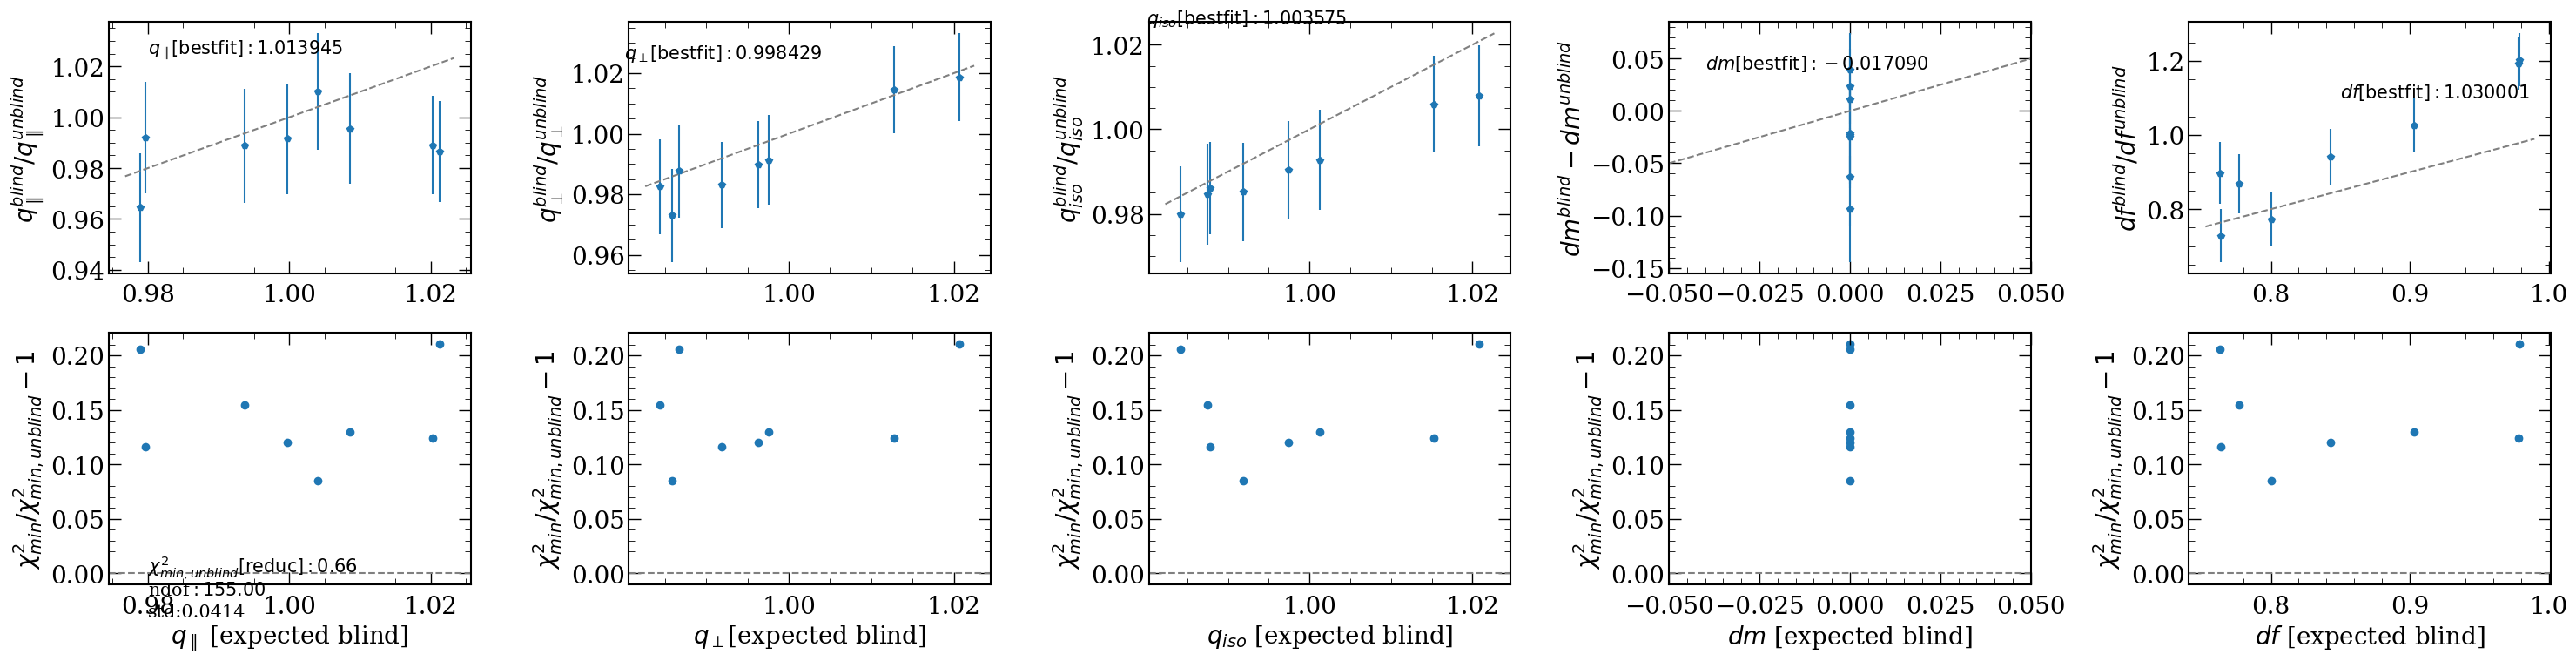

In [23]:
fig, ax = plt.subplots(2, 5, sharex='col')

ax[0, 0].errorbar(expected['qpar'], bestfit['qpar'] / bestfit_unblinded['qpar'], yerr=error['qpar'], fmt='p') #row=0, col=0
ax[0, 0].tick_params('x', labelbottom=True)
ax[0, 0].set(ylabel=r'$q_{\parallel}^{blind} / q_{\parallel}^{unblind}$')
ax[0, 0].plot(ax[0, 0].get_xlim(), ax[0, 0].get_xlim(), c='gray', linestyle='--')
ax[0, 0].text(0.98, 1.025, r'$q_{\parallel}{\rm[bestfit]}: %f$' % (bestfit_unblinded['qpar']), fontsize=15)

ax[1, 0].scatter(expected['qpar'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=0
ax[1, 0].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$q_{\parallel}$ [expected blind]')
ax[1, 0].axhline(y=0., color='gray', linestyle='--')
chi2min_red = bestfit_unblinded['chi2min'] / chain_unblinded.attrs['ndof']

if clustering_statistics == 'pk':
    ax[1, 0].text(0.98, 0., r'$\chi^2_{min, unblind}{\rm[reduc]}: %.2f$' % (chi2min_red), fontsize=15)
    chi2min_std = np.array(bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.).std()
    ax[1, 0].text(0.98, -0.04, r'std:{:.3}'.format(chi2min_std), fontsize=15)
    ax[1, 0].text(0.98, -0.02, r'ndof$: %.2f$' % (chain_unblinded.attrs['ndof']), fontsize=15)
else:
    ax[1, 0].text(0.98, 0.2, r'$\chi^2_{min, unblind}{\rm[reduc]}: %.2f$' % (chi2min_red), fontsize=15)
    chi2min_std = np.array(bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.).std()
    ax[1, 0].text(0.98, 0.1, r'std:{:.3}'.format(chi2min_std), fontsize=15)
    ax[1, 0].text(0.98, 0.15, r'ndof$: %.2f$' % (chain_unblinded.attrs['ndof']), fontsize=15)


ax[0, 1].errorbar(expected['qper'], bestfit['qper'] / bestfit_unblinded['qper'], yerr=error['qper'], fmt='p') #row=0, col=1
ax[0, 1].tick_params('x', labelbottom=True)
ax[0, 1].set( ylabel=r'$q_{\perp}^{blind} / q_{\perp}^{unblind}$')
ax[0, 1].plot(ax[0, 1].get_xlim(), ax[0, 1].get_xlim(), c='gray', linestyle='--')
ax[0, 1].text(0.98, 1.025, r'$q_{\perp}{\rm[bestfit]}: %f$' % (bestfit_unblinded['qper']), fontsize=15)

ax[1, 1].scatter(expected['qper'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=1
ax[1, 1].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$q_{\perp}$[expected blind]')
ax[1, 1].axhline(y=0., color='gray', linestyle='--')

ax[0, 2].errorbar(expected['qiso'], bestfit['qiso'] / bestfit_unblinded['qiso'], yerr=error['qiso'], fmt='p') #row=0, col=0
ax[0, 2].tick_params('x', labelbottom=True)
ax[0, 2].set(ylabel=r'$q_{iso}^{blind} / q_{iso}^{unblind}$')
ax[0, 2].plot(ax[0, 2].get_xlim(), ax[0, 2].get_xlim(), c='gray', linestyle='--')
ax[0, 2].text(0.98, 1.025, r'$q_{iso}{\rm[bestfit]}: %f$' % (bestfit_unblinded['qiso']), fontsize=15)

ax[1, 2].scatter(expected['qiso'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=0
ax[1, 2].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$q_{iso}$ [expected blind]')
ax[1, 2].axhline(y=0., color='gray', linestyle='--')

ax[0, 3].errorbar(expected['dm'], bestfit['dm'] - bestfit_unblinded['dm'], yerr=error['dm'], fmt='p') #row=0, col=0
ax[0, 3].tick_params('x', labelbottom=True)
ax[0, 3].set(ylabel=r'$dm^{blind} - dm^{unblind}$')
ax[0, 3].set_xlim(-0.05, 0.05)
ax[0, 3].plot(ax[0, 3].get_xlim(), ax[0, 3].get_xlim(), c='gray', linestyle='--')
ax[0, 3].text(-0.04, 0.04, r'$dm{\rm[bestfit]}: %f$' % (bestfit_unblinded['dm']), fontsize=15)

ax[1, 3].scatter(expected['dm'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=0
ax[1, 3].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$dm$ [expected blind]')
ax[1, 3].axhline(y=0., color='gray', linestyle='--')

ax[0, 4].errorbar(expected['df'], bestfit['df'] / bestfit_unblinded['df'], yerr=error['df'], fmt='p') #row=0, col=0
ax[0, 4].tick_params('x', labelbottom=True)
ax[0, 4].set(ylabel=r'$df^{blind} / df^{unblind}$')
ax[0, 4].plot(ax[0, 4].get_xlim(), ax[0, 4].get_xlim(), c='gray', linestyle='--')
ax[0, 4].text(0.85, 1.1, r'$df{\rm[bestfit]}: %f$' % (bestfit_unblinded['df']), fontsize=15)

ax[1, 4].scatter(expected['df'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=0
ax[1, 4].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$df$ [expected blind]')
ax[1, 4].axhline(y=0., color='gray', linestyle='--')

# if clustering_statistics == 'pk':
#     fig.suptitle('Covariance generated individually for each blinded cosmology. {}_{}_{}_{}'.format(tracer, region, zmin, zmax), fontsize=18)
# else:
#     fig.suptitle('Same covariance generated with unblinded cosmology. {}_{}_{}_{}'.format(tracer, region, zmin, zmax), fontsize=18)

plt.tight_layout()
# plt.savefig(os.path.join(base_dir, 'blinded', '{}_one2one_plot_{}_{}_{}_{}.png'.format(clustering_statistics, tracer, region, zmin, zmax)))
plt.show()